In [1]:
%cd ..
%reload_ext autoreload
%autoreload 2

D:\ownCloud\Uni\Semester Ma 5\3D Scanning & Motion Capture (IN2354)\Project\3D-FaceReconstruction


In [2]:
import cv2
import pyrender
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import tqdm

from face_reconstruction.landmarks import load_bfm_landmarks, detect_landmarks
from face_reconstruction.model import BaselFaceModel
from face_reconstruction.graphics import SimpleImageRenderer, draw_pixels_to_image
from face_reconstruction.optim import SparseOptimization, SparseOptimizationParameters
from face_reconstruction.utils.timing import Timing
from face_reconstruction.plots import PlotManager
from env import DATA_PATH

# 1. Setup Model, Image and Rendering 

In [3]:
bfm = BaselFaceModel.from_h5("model2019_face12.h5")
bfm_landmarks = load_bfm_landmarks("model2019_face12_landmarks_v2")
bfm_landmark_indices = list(bfm_landmarks.values())

In [4]:
img_path = f"{DATA_PATH}/Keypoint Detection/trump.jpg"
img = cv2.imread(img_path)
landmarks_img = detect_landmarks(img)
img_width = img.shape[1]
img_height = img.shape[0]

In [5]:
perspective_camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
projection_matrix = perspective_camera.get_projection_matrix(width=img_width, height=img_height)
renderer = SimpleImageRenderer(projection_matrix, img_width, img_height)

# 2. Setup Optimization

In [6]:
def run_optimization(sparse_optimization):
    initial_params = sparse_optimization.create_parameters(
        [0 for _ in range(bfm.get_n_shape_coefficients())],
        [0 for _ in range(bfm.get_n_expression_coefficients())],
        np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -300], [0, 0, 0, 1]])
    )
    loss = sparse_optimization.create_loss(renderer, bfm_landmark_indices, landmarks_img)
    result = optimize.least_squares(loss, initial_params.to_theta(), max_nfev=100, gtol=1e-15)
    return result

# 3. Benchmarks

In [7]:
plot_manager = PlotManager("sparse_reconstruction_benchmarks")

## 3.1 Benchmark impact of weighting shape parameters

In [8]:
n_params_shape = 10
n_params_expression = 0
shape_weights = [100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [9]:
costs_by_shape_weight = []
runtimes_by_shape_weight = []
for weight in tqdm(shape_weights):
    sparse_optimization = SparseOptimization(bfm, n_params_shape, n_params_expression, weight_shape_params=weight)
    with Timing() as t:
        result = run_optimization(sparse_optimization)
        runtimes_by_shape_weight.append(t)
    costs_by_shape_weight.append(result.cost)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:35<00:00,  8.67s/it]


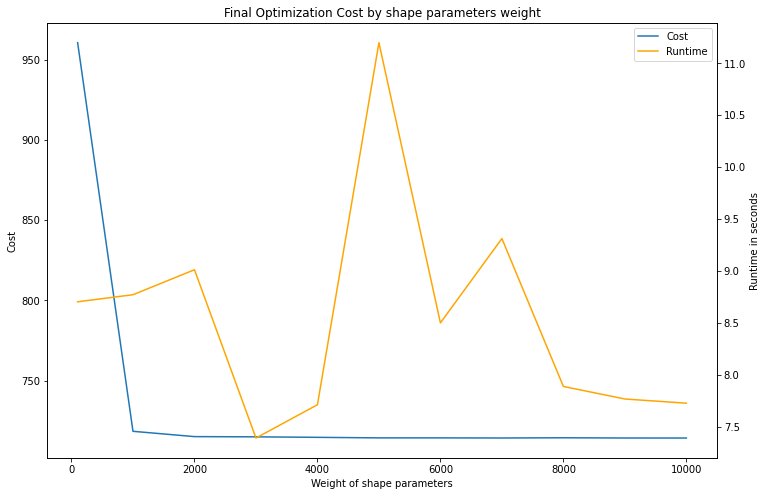

In [10]:
plt.figure(figsize=(12, 8))
plt.title("Final Optimization Cost by shape parameters weight")

line_cost = plt.plot(shape_weights, costs_by_shape_weight, label='Cost')
plt.ylabel('Cost')
plt.xlabel('Weight of shape parameters')

ax2 = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis
line_time = ax2.plot(shape_weights, runtimes_by_shape_weight, color='orange', label='Runtime')
plt.ylabel('Runtime in seconds')

lns = line_cost + line_time
labs = [l.get_label() for l in lns]
plt.legend(lns, labs)

plot_manager.save_current_plot("benchmark_cost_by_shape_params_weight.pdf")
plt.show()

In [11]:
## 3.2 Benchmark impact of weighting expression parameters

In [12]:
n_params_shape = 5
n_params_expression = 10
expression_weights =[100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [13]:
costs_by_expression_weight = []
runtimes_by_expression_weight = []
for weight in tqdm(expression_weights):
    sparse_optimization = SparseOptimization(bfm, n_params_shape, n_params_expression, weight_expression_params=weight)
    with Timing() as t:
        result = run_optimization(sparse_optimization)
        runtimes_by_expression_weight.append(t)
    costs_by_expression_weight.append(result.cost)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:05<00:00, 11.45s/it]


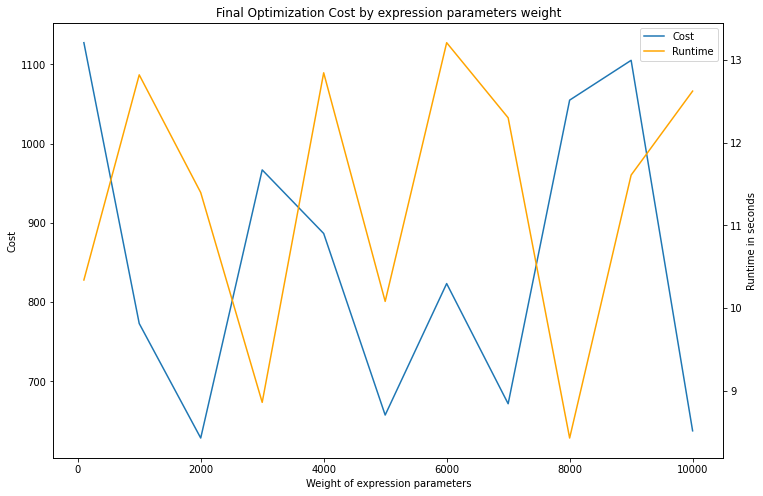

In [14]:
plt.figure(figsize=(12, 8))
plt.title("Final Optimization Cost by expression parameters weight")

line_cost = plt.plot(expression_weights, costs_by_expression_weight, label='Cost')
plt.ylabel('Cost')
plt.xlabel('Weight of expression parameters')

ax2 = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis
line_time = ax2.plot(expression_weights, runtimes_by_expression_weight, color='orange', label='Runtime')
plt.ylabel('Runtime in seconds')

lns = line_cost + line_time
labs = [l.get_label() for l in lns]
plt.legend(lns, labs)

plot_manager.save_current_plot("benchmark_cost_by_expression_params_weight.pdf")
plt.show()

# 3.3 Benchmark number of Shape parameters

In [15]:
n_params_shape = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
n_params_expression = 5
weight_face_parameters = 1000

In [16]:
costs_by_shape_param = []
runtimes_by_shape_param = []
for param_shape in tqdm(n_params_shape):
    sparse_optimization = SparseOptimization(bfm, n_params_shape=param_shape, n_params_expression=n_params_expression, weight_shape_params=weight_face_parameters, weight_expression_params=weight_face_parameters)
    with Timing() as t:
        result = run_optimization(sparse_optimization)
        runtimes_by_shape_param.append(t)
    costs_by_shape_param.append(result.cost)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:20<00:00, 23.70s/it]


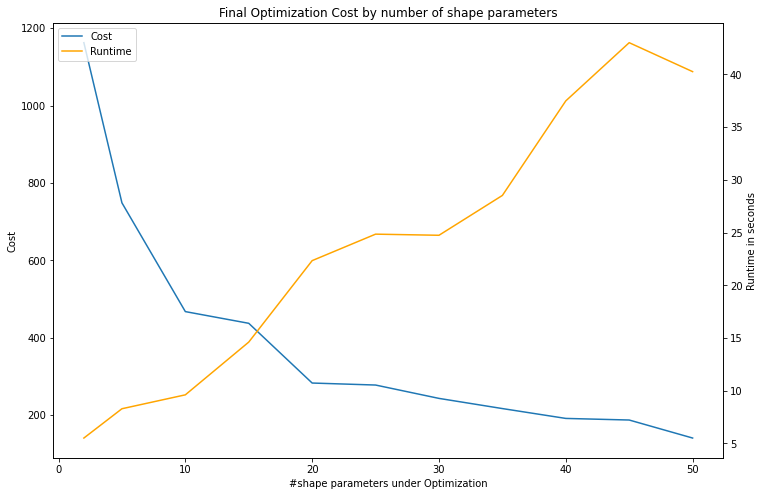

In [17]:
plt.figure(figsize=(12, 8))
plt.title("Final Optimization Cost by number of shape parameters")

line_cost = plt.plot(n_params_shape, costs_by_shape_param, label='Cost')
plt.ylabel('Cost')
plt.xlabel('#shape parameters under Optimization')

ax2 = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis
line_time = ax2.plot(n_params_shape, runtimes_by_shape_param, color='orange', label='Runtime')
plt.ylabel('Runtime in seconds')

lns = line_cost + line_time
labs = [l.get_label() for l in lns]
plt.legend(lns, labs)

plot_manager.save_current_plot("benchmark_cost_by_n_shape_params.pdf")
plt.show()

# 3.4 Benchmark number of expression parameters

In [18]:
n_params_shape = 10
n_params_expression = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
weight_face_parameters = 1000

In [19]:
costs_by_expression_param = []
runtimes_by_expression_param = []
for param_expression in tqdm(n_params_expression):
    sparse_optimization = SparseOptimization(bfm, n_params_shape=n_params_shape, n_params_expression=param_expression, weight_shape_params=weight_face_parameters, weight_expression_params=weight_face_parameters)
    with Timing() as t:
        result = run_optimization(sparse_optimization)
        runtimes_by_expression_param.append(t)
    costs_by_expression_param.append(result.cost)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:49<00:00, 26.29s/it]


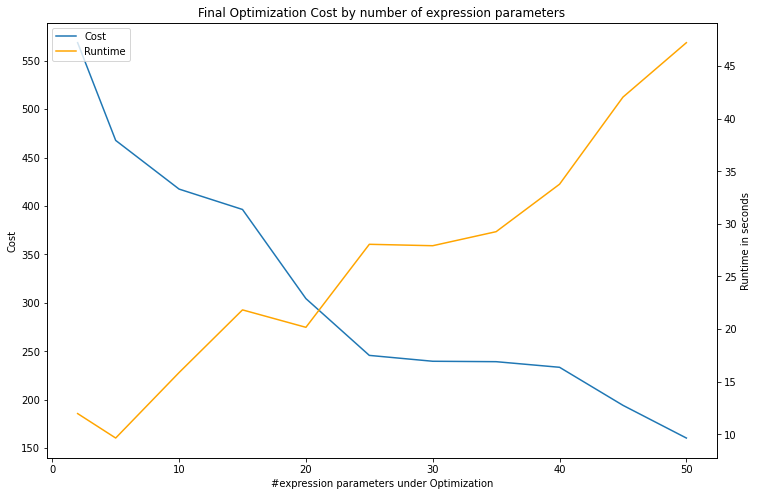

In [20]:
plt.figure(figsize=(12, 8))
plt.title("Final Optimization Cost by number of expression parameters")

line_cost = plt.plot(n_params_expression, costs_by_expression_param, label='Cost')
plt.ylabel('Cost')
plt.xlabel('#expression parameters under Optimization')

ax2 = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis
line_time = ax2.plot(n_params_expression, runtimes_by_expression_param, color='orange', label='Runtime')
plt.ylabel('Runtime in seconds')

lns = line_cost + line_time
labs = [l.get_label() for l in lns]
plt.legend(lns, labs)

plot_manager.save_current_plot("benchmark_cost_by_n_expression_params.pdf")
plt.show()